In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

1. 데이터의 중복 제거

2. NaN 결측치 제거

3. 한국어 토크나이저로 토큰화

4. 불용어(Stopwords) 제거

5. 사전 word_to_index 구성

6. 텍스트 스트링을 사전 인덱스 스트링으로 변환

7. X_train, y_train, X_test, y_test, word_to_index 리턴

In [61]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=["document"],inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=["document"], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data["document"]:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data["document"]:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    # 토큰화된 단어 리스트들의 리스트 -> 하나의 리스트 결합
    words = np.concatenate(X_train).tolist()
    # 단어 빈도수 계산
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    # 인덱스 0~3은 특수 토큰용으로 비움
    vocab = [' ',' ',' ',' '] + [key for key, _ in counter]
    # 딕셔너리 생성
    word_to_index = {word: index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[' '] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [62]:
index_to_word = {index:word for word, index in word_to_index.items()}

인코더 디코더 함수

In [63]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [64]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [65]:
print(len(X_train))
print(len(word_to_index))

146182
9997


## 모델 구성을 위한 데이터 분석 및 가공

1. 데이터셋 내 문장 길이 분포
2. 적절한 최대 문장 길이 지정


In [66]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [67]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index[" "],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index[" "],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 평가지표 시각화 함수

In [136]:
import matplotlib.pyplot as plt

def acc_loss_graph(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # 왼쪽: Loss
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # 오른쪽: Accuracy
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()


## 컴파일 모델 함수화

In [180]:
def compile_model(model, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


In [297]:
# validation set 80000건 분리
x_val = X_train[:80000]   
y_val = y_train[:80000]

# validation set을 제외한 나머지 66182건
partial_x_train = X_train[80000:]  
partial_y_train = y_train[80000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(66182, 41)
(66182,)


## 1번 모델 (LSTM)
LSTM.layer: 16

Dense.layer: 16

In [141]:
vocab_size = 9997
word_vector_dim = 32
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(16,activation="relu"))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

In [142]:
# 권장 차원 수 = log(어휘 수) × k, 보통 k는 10~20 사이
# dim_num = (vocab_size ** 0.5) * 10
# print(int(dim_num))
# 너무 많아서 패스

In [144]:
model = compile_model(model)
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
130/130 [==============================] - 3s 10ms/step - loss: 0.5579 - accuracy: 0.7283 - val_loss: 0.4047 - val_accuracy: 0.8327
Epoch 2/20
130/130 [==============================] - 1s 7ms/step - loss: 0.3568 - accuracy: 0.8513 - val_loss: 0.3634 - val_accuracy: 0.8441
Epoch 3/20
130/130 [==============================] - 1s 7ms/step - loss: 0.3179 - accuracy: 0.8682 - val_loss: 0.3633 - val_accuracy: 0.8438
Epoch 4/20
130/130 [==============================] - 1s 7ms/step - loss: 0.3006 - accuracy: 0.8775 - val_loss: 0.3683 - val_accuracy: 0.8417
Epoch 5/20
130/130 [==============================] - 1s 7ms/step - loss: 0.2880 - accuracy: 0.8837 - val_loss: 0.3777 - val_accuracy: 0.8411
Epoch 6/20
130/130 [==============================] - 1s 7ms/step - loss: 0.2785 - accuracy: 0.8881 - val_loss: 0.3778 - val_accuracy: 0.8398
Epoch 7/20
130/130 [==============================] - 1s 7ms/step - loss: 0.2700 - accuracy: 0.8928 - val_loss: 0.3861 - val_accuracy: 0.8388
Epoch

In [145]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6220 - accuracy: 0.8189
[0.6219878792762756, 0.8189271092414856]


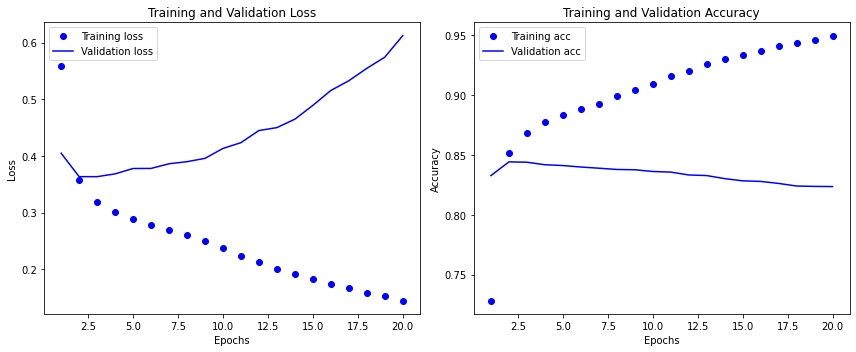

In [146]:
acc_loss_graph(history.history)

### 과적합이 빠르게 발생 ! 드롭아웃 층 추가해보자


## 2번 모델 (LSTM + (recurrent)Dropout + eralystopping) + LSTM레이어수 추가
과적합이 빠르게 발생하여 연결층을 분리하는 Dropout을 추가하여 2번모델 학습

In [147]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.3))
model.add(tf.keras.layers.Dense(16,activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

In [150]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)

model = compile_model(model)

history_lstm_drop = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[callback])

Epoch 1/20
130/130 [==============================] - 24s 172ms/step - loss: 0.5612 - accuracy: 0.7131 - val_loss: 0.3910 - val_accuracy: 0.8335
Epoch 2/20
130/130 [==============================] - 22s 171ms/step - loss: 0.3891 - accuracy: 0.8436 - val_loss: 0.3620 - val_accuracy: 0.8420
Epoch 3/20
130/130 [==============================] - 22s 169ms/step - loss: 0.3498 - accuracy: 0.8630 - val_loss: 0.3643 - val_accuracy: 0.8417
Epoch 4/20
130/130 [==============================] - 22s 170ms/step - loss: 0.3303 - accuracy: 0.8717 - val_loss: 0.3617 - val_accuracy: 0.8440
Epoch 5/20
130/130 [==============================] - 22s 170ms/step - loss: 0.3171 - accuracy: 0.8777 - val_loss: 0.3678 - val_accuracy: 0.8406
Epoch 6/20
130/130 [==============================] - 22s 169ms/step - loss: 0.3013 - accuracy: 0.8843 - val_loss: 0.3645 - val_accuracy: 0.8404


In [151]:
results_lstm_drop = model.evaluate(X_test,  y_test, verbose=2)

print(results_lstm_drop)

1537/1537 - 17s - loss: 0.3689 - accuracy: 0.8403
[0.3689408600330353, 0.8402872681617737]


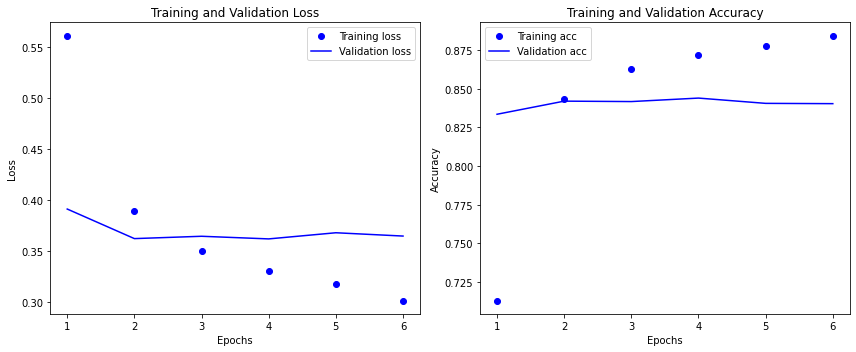

In [152]:
acc_loss_graph(history_lstm_drop.history)

### accuracy : 0.8189 -> 0.8403  (2.14% 성능향상)

Dropout층을 추가하여 2.14% 성능향상을 보임

EarlyStopping 6에서 멈춤

## 모델3: LSTM으로 끌어올릴 수 있는 성능이 한계가 보임 다른 모델을 사용 -> 1D CNN


In [336]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [337]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)

model = compile_model(model)

history_cnn = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[callback])

Epoch 1/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4806 - accuracy: 0.7743 - val_loss: 0.3489 - val_accuracy: 0.8476
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3374 - accuracy: 0.8655 - val_loss: 0.3373 - val_accuracy: 0.8545
Epoch 3/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2881 - accuracy: 0.8912 - val_loss: 0.3352 - val_accuracy: 0.8559
Epoch 4/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2407 - accuracy: 0.9128 - val_loss: 0.3529 - val_accuracy: 0.8540
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.1940 - accuracy: 0.9327 - val_loss: 0.3877 - val_accuracy: 0.8503


In [300]:
results_cnn = model.evaluate(X_test,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 2s - loss: 0.3536 - accuracy: 0.8456
[0.3535933792591095, 0.8455967903137207]


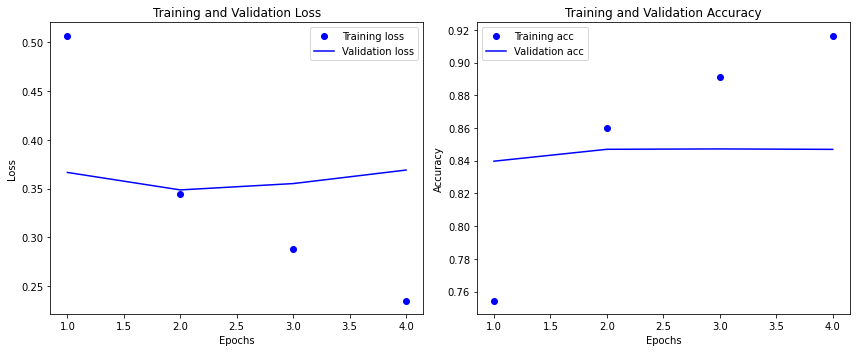

In [301]:
acc_loss_graph(history_cnn.history)

### accuracy : 0.8403 -> 0.8463  (0.6% 성능향상)

Dropout층을 추가하여 0.6% 성능향상을 보임

EarlyStopping 5에서 멈춤

### 2번모델과 정확도면에서도 앞서고 훨씬 빠른속도로 학습이 되었음 

## BestModel 3번 !

---

### 과적합이 너무 빨라 데이터셋을 추가

In [302]:
# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 96182건
partial_x_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [330]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(64, 4, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)

model = compile_model(model)

history_cnn = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[callback])

Epoch 1/20
188/188 [==============================] - 2s 6ms/step - loss: 0.4779 - accuracy: 0.7768 - val_loss: 0.3512 - val_accuracy: 0.8456
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3344 - accuracy: 0.8658 - val_loss: 0.3328 - val_accuracy: 0.8552
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2821 - accuracy: 0.8938 - val_loss: 0.3338 - val_accuracy: 0.8571
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2296 - accuracy: 0.9178 - val_loss: 0.3475 - val_accuracy: 0.8564


In [331]:
results_cnn = model.evaluate(X_test,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 2s - loss: 0.3395 - accuracy: 0.8539
[0.3395414352416992, 0.8538763523101807]


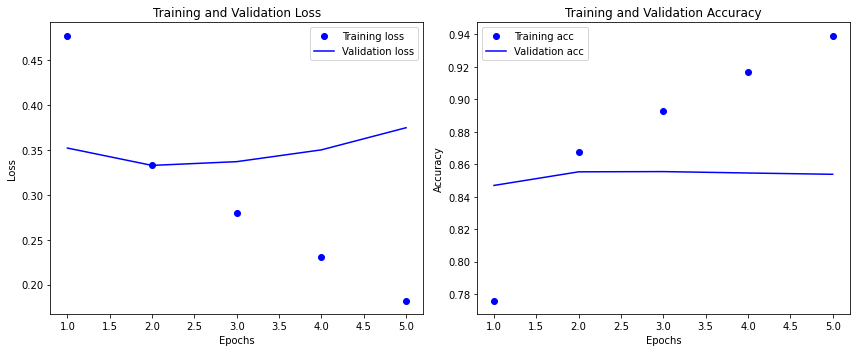

In [327]:
acc_loss_graph(history_cnn.history)

## accuracy: 0.8539 <- Best

# word2vec 적용

In [181]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/aiffel/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']


In [182]:
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

## 자체 학습한 임베딩 모델

In [345]:
from gensim.models import Word2Vec

decoded_sentences = get_decoded_sentences(X_train, index_to_word)


sentences_for_w2v = [sentence.split() for sentence in decoded_sentences]

w2v_model = Word2Vec(sentences=sentences_for_w2v, vector_size=100, window=5, min_count=2, sg=1)

## 사전 학습된 임베딩 모델

In [183]:
from gensim.models import KeyedVectors

word2vec_file_path = '/aiffel/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_file_path)

In [187]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(10,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

## 두 모델 성능 비교

In [341]:
word2vec.wv.most_similar('영화')

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

In [348]:
w2v_model.wv.most_similar("영화")

[('애니메이션', 0.7108631730079651),
 ('공포물', 0.6911563873291016),
 ('영회', 0.6838723421096802),
 ('드라마', 0.6834842562675476),
 ('영환데', 0.6575459837913513),
 ('작품', 0.6505294442176819),
 ('영활', 0.6439788937568665),
 ('애니', 0.6439204216003418),
 ('강시', 0.6418247222900391),
 ('영호', 0.6407393217086792)]

### 자체학습한 모델은 영화와 비슷한 단어를 단순하게 비슷한 글자인 영호 영회 등을 주목함
### 반면 사전학습된 모델은 다큐멘터리, 뮤지컬과 같이 속성이 비슷한 단어를 잘 잡아냄

In [314]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.Conv1D(32, 2, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))



callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

model = compile_model(model)

history_cnn_word2vec = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[callback])

Epoch 1/20
188/188 [==============================] - 2s 6ms/step - loss: 0.8714 - accuracy: 0.5311 - val_loss: 0.6750 - val_accuracy: 0.6132
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.6569 - accuracy: 0.5995 - val_loss: 0.5947 - val_accuracy: 0.7068
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.5901 - accuracy: 0.6750 - val_loss: 0.5231 - val_accuracy: 0.7572
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.5384 - accuracy: 0.7264 - val_loss: 0.4724 - val_accuracy: 0.7841
Epoch 5/20
188/188 [==============================] - 1s 5ms/step - loss: 0.4999 - accuracy: 0.7650 - val_loss: 0.4468 - val_accuracy: 0.7993
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 0.4655 - accuracy: 0.7944 - val_loss: 0.4221 - val_accuracy: 0.8134
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.4409 - accuracy: 0.8106 - val_loss: 0.4008 - val_accuracy: 0.8212
Epoch 

In [315]:
result_cnn_word2vec = model.evaluate(X_test,  y_test, verbose=2)

print(result_cnn_word2vec)

1537/1537 - 2s - loss: 0.3762 - accuracy: 0.8333
[0.37616515159606934, 0.8333299160003662]


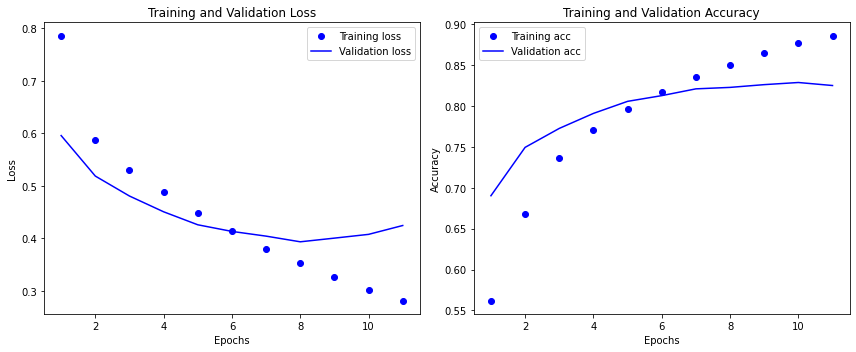

In [178]:
acc_loss_graph(history_cnn_word2vec.history)

In [332]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))  
model.add(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.3))
model.add(tf.keras.layers.Dense(16,activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

model = compile_model(model)

history_lstm_word2vec = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[callback])

Epoch 1/20
188/188 [==============================] - 33s 167ms/step - loss: 0.6366 - accuracy: 0.6371 - val_loss: 0.5089 - val_accuracy: 0.7568
Epoch 2/20
188/188 [==============================] - 31s 165ms/step - loss: 0.5165 - accuracy: 0.7642 - val_loss: 0.4204 - val_accuracy: 0.8089
Epoch 3/20
188/188 [==============================] - 31s 166ms/step - loss: 0.4577 - accuracy: 0.8020 - val_loss: 0.3882 - val_accuracy: 0.8260
Epoch 4/20
188/188 [==============================] - 32s 168ms/step - loss: 0.4235 - accuracy: 0.8183 - val_loss: 0.3656 - val_accuracy: 0.8390
Epoch 5/20
188/188 [==============================] - 31s 163ms/step - loss: 0.4013 - accuracy: 0.8304 - val_loss: 0.3539 - val_accuracy: 0.8447
Epoch 6/20
188/188 [==============================] - 31s 163ms/step - loss: 0.3852 - accuracy: 0.8406 - val_loss: 0.3471 - val_accuracy: 0.8491
Epoch 7/20
188/188 [==============================] - 31s 165ms/step - loss: 0.3722 - accuracy: 0.8469 - val_loss: 0.3426 - val_ac

In [333]:
result_lstm_word2vec = model.evaluate(X_test,  y_test, verbose=2)

print(result_lstm_word2vec)

1537/1537 - 18s - loss: 0.3425 - accuracy: 0.8534
[0.34247010946273804, 0.8534491658210754]


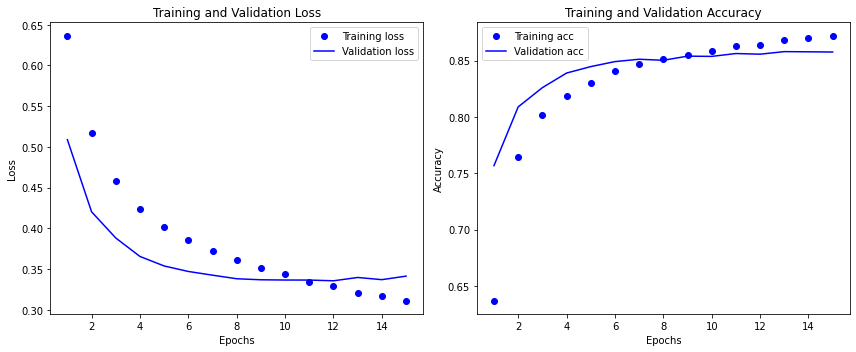

In [334]:
acc_loss_graph(history_lstm_word2vec.history)

### 0.8403 -> 0.8543 (1.5% 성능향상) 

# LSTM + Word2Vec / acc : 0.8534 - Best

## CNN은 word2vec을 적용하면 성능이 떨어지고 LSTM은 올라간다 ?

### Word2Vec은 단어 간 의미 관계를 벡터로 표현한 것 문장 내 순서나 문맥 흐름은 담고 있지 않음
### 순서를 학습하는 LSTM이 잘 활용
### 지역 패턴만 보는 CNN은 오히려 방해

# 회고
---
무조건 LSTM이 최고일 줄 알았지만 오히려 word2vec을 적용시키기 전에는 1DCNN이 훨씬 성능과 속도측면에 좋았던 것이 놀라웠다.
단어 임베딩의 단어 유사도를 조사할 때 자체 학습한 모델은 "영회"라는 단어를 볼 수 있엇는데 실제로 "영화" -> "영회"로 오타가 나는 경우가 많을 것 같다.
이 부분은 오히려 제대로 학습못한 자체학습 모델이 더 잘 잡아낸게 아닐까? 라는 생각이 들었다.